In [134]:
import json
import requests 
import pandas as pd 
import datetime
import matplotlib.pyplot as pyplot
import seaborn as sns 

## Extraction 

In [135]:
cities = [
    {"name": "Rabat", "lat": 34.0209, "lon": -6.8417},
    {"name": "Casablanca", "lat": 33.5731, "lon": -7.5898},
    {"name": "Marrakech", "lat": 31.6295, "lon": -7.9811},
    {"name": "Fès", "lat": 34.0331, "lon": -4.9998},
    {"name": "Agadir", "lat": 30.4278, "lon": -9.5981},
    {"name": "Tangier", "lat": 35.7595, "lon": -5.8339},
    {"name": "Meknès", "lat": 33.8935, "lon": -5.5473},
    {"name": "Oujda", "lat": 34.6805, "lon": -1.8993},
    {"name": "Kenitra", "lat": 34.2644, "lon": -6.5796},
    {"name": "Tétouan", "lat": 35.577, "lon": -5.3684},
    {"name": "Safi", "lat": 32.3008, "lon": -9.2319},
    {"name": "El Jadida", "lat": 33.2568, "lon": -8.5088},
    {"name": "Nador", "lat": 35.1681, "lon": -2.9335},
    {"name": "Laâyoune", "lat": 27.1622, "lon": -13.2034},
    {"name": "Taza", "lat": 34.208, "lon": -3.9986},
    {"name": "Essaouira", "lat": 31.5085, "lon": -9.7595},
    {"name": "Ifrane", "lat": 33.5333, "lon": -5.1167},
    {"name": "Taroudant", "lat": 30.4708, "lon": -8.8763},
    {"name": "Errachidia", "lat": 31.9314, "lon": -4.4244},
    {"name": "Ouarzazate", "lat": 30.916, "lon": -6.9274},
    {"name": "Ksar El Kebir", "lat": 35.0028, "lon": -5.9033},
    {"name": "Al Hoceima", "lat": 35.251, "lon": -3.9372},
    {"name": "Guelmim", "lat": 28.987, "lon": -10.0574},
    {"name": "Settat", "lat": 33.0011, "lon": -7.6162},
]


In [136]:
import requests
import pandas as pd

API_KEY = "a4659790aaec418606aac9a4cec9d663"  

weather_data = []

for city in cities:
    # Utilisation de l'API 'forecast' pour obtenir les prévisions sur 5 jours avec une fréquence horaire (donc 3 heures par intervalle)
    url = f"http://api.openweathermap.org/data/2.5/forecast?lat={city['lat']}&lon={city['lon']}&appid={API_KEY}&units=metric"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Extraction des prévisions pour chaque jour (dans l'intervalle de 5 jours)
        for day in data['list']:
            weather_data.append({
                "City": city["name"],
                "Date": pd.to_datetime(day["dt"], unit="s"),  # Convertir le timestamp en date
                "Temperature": day["main"]["temp"],
                "Weather": day["weather"][0]["description"],
                "Pressure": day["main"]["pressure"],
                "Humidity": day["main"]["humidity"],
                "Wind Speed": day["wind"]["speed"]
            })
    else:
        print(f"Failed to fetch data for {city['name']} (status code {response.status_code})")

# Convertir les données collectées en DataFrame
df = pd.DataFrame(weather_data)
print(df)


       City                Date  Temperature           Weather  Pressure  \
0     Rabat 2025-01-28 15:00:00        18.74        few clouds      1032   
1     Rabat 2025-01-28 18:00:00        17.09        few clouds      1031   
2     Rabat 2025-01-28 21:00:00        14.99         clear sky      1032   
3     Rabat 2025-01-29 00:00:00        13.38         clear sky      1031   
4     Rabat 2025-01-29 03:00:00        12.90         clear sky      1030   
..      ...                 ...          ...               ...       ...   
955  Settat 2025-02-02 00:00:00         6.41     broken clouds      1023   
956  Settat 2025-02-02 03:00:00         7.45  scattered clouds      1023   
957  Settat 2025-02-02 06:00:00         9.06     broken clouds      1022   
958  Settat 2025-02-02 09:00:00        10.31   overcast clouds      1022   
959  Settat 2025-02-02 12:00:00        14.02     broken clouds      1021   

     Humidity  Wind Speed  
0          60        3.67  
1          70        2.24  
2  

## Transformation 

In [137]:
df['temp_rolling_avg'] = df['Temperature'].rolling(window=3).mean()


In [138]:
df.fillna(method='ffill', inplace=True)  # Remplir les valeurs manquantes avec la valeur précédente


C:\Users\dell\AppData\Local\Temp\ipykernel_17752\2180507842.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Remplir les valeurs manquantes avec la valeur précédente


In [139]:

# Fonction pour calculer l'indice de chaleur
def calculate_heat_index(temp_c, humidity):
    c1 = -8.78469475556
    c2 = 1.61139411
    c3 = 2.33854883889
    c4 = -0.14611605
    c5 = -0.012308094
    c6 = -0.0164248271
    c7 = 0.002211732
    c8 = 0.00072546
    c9 = -0.000003582

    HI = (c1 + c2 * temp_c + c3 * humidity + c4 * temp_c * humidity +
          c5 * temp_c ** 2 + c6 * humidity ** 2 + c7 * temp_c ** 2 * humidity +
          c8 * temp_c * humidity ** 2 + c9 * temp_c ** 2 * humidity ** 2)
    return HI

# Fonction pour calculer l'indice de refroidissement éolien
def calculate_wind_chill(temp_c, wind_speed):
    WC = 13.12 + 0.6215 * temp_c - 11.37 * wind_speed ** 0.16 + 0.3965 * temp_c * wind_speed ** 0.16
    return WC


In [140]:
# Fonction pour calculer l'indice de refroidissement éolien (Wind Chill)
def calculate_wind_chill(temp_c, wind_speed):
    WC = 13.12 + 0.6215 * temp_c - 11.37 * wind_speed ** 0.16 + 0.3965 * temp_c * wind_speed ** 0.16
    return WC

In [141]:
# Ajouter les colonnes Heat Index et Wind Chill à votre DataFrame
df['Heat Index'] = df.apply(lambda row: calculate_heat_index(row['Temperature'], row['Humidity']), axis=1)
df['Wind Chill'] = df.apply(lambda row: calculate_wind_chill(row['Temperature'], row['Wind Speed']), axis=1)

# Afficher le DataFrame avec les nouvelles colonnes
print(df)

       City                Date  Temperature           Weather  Pressure  \
0     Rabat 2025-01-28 15:00:00        18.74        few clouds      1032   
1     Rabat 2025-01-28 18:00:00        17.09        few clouds      1031   
2     Rabat 2025-01-28 21:00:00        14.99         clear sky      1032   
3     Rabat 2025-01-29 00:00:00        13.38         clear sky      1031   
4     Rabat 2025-01-29 03:00:00        12.90         clear sky      1030   
..      ...                 ...          ...               ...       ...   
955  Settat 2025-02-02 00:00:00         6.41     broken clouds      1023   
956  Settat 2025-02-02 03:00:00         7.45  scattered clouds      1023   
957  Settat 2025-02-02 06:00:00         9.06     broken clouds      1022   
958  Settat 2025-02-02 09:00:00        10.31   overcast clouds      1022   
959  Settat 2025-02-02 12:00:00        14.02     broken clouds      1021   

     Humidity  Wind Speed  temp_rolling_avg  Heat Index  Wind Chill  
0          60    

In [142]:
print(df.columns
      )

Index(['City', 'Date', 'Temperature', 'Weather', 'Pressure', 'Humidity',
       'Wind Speed', 'temp_rolling_avg', 'Heat Index', 'Wind Chill'],
      dtype='object')


#### Categorisation 

In [143]:
def wind_speed_category(speed):
    if speed < 5:
        return "Léger"
    elif speed < 15:
        return "Modéré"
    else:
        return "Fort"

df['Wind speed category'] = df['Wind Speed'].apply(wind_speed_category)

def humidity_category(humidity):
    if humidity < 40:
        return "Faible"
    elif humidity < 70:
        return "Modéré"
    else:
        return "Elevé"

df['Humidity category'] = df['Humidity'].apply(humidity_category)


In [144]:
df.fillna(method='ffill', inplace=True)  # Remplir les valeurs manquantes avec la valeur précédente


C:\Users\dell\AppData\Local\Temp\ipykernel_17752\2180507842.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Remplir les valeurs manquantes avec la valeur précédente


In [145]:
print(df)

       City                Date  Temperature           Weather  Pressure  \
0     Rabat 2025-01-28 15:00:00        18.74        few clouds      1032   
1     Rabat 2025-01-28 18:00:00        17.09        few clouds      1031   
2     Rabat 2025-01-28 21:00:00        14.99         clear sky      1032   
3     Rabat 2025-01-29 00:00:00        13.38         clear sky      1031   
4     Rabat 2025-01-29 03:00:00        12.90         clear sky      1030   
..      ...                 ...          ...               ...       ...   
955  Settat 2025-02-02 00:00:00         6.41     broken clouds      1023   
956  Settat 2025-02-02 03:00:00         7.45  scattered clouds      1023   
957  Settat 2025-02-02 06:00:00         9.06     broken clouds      1022   
958  Settat 2025-02-02 09:00:00        10.31   overcast clouds      1022   
959  Settat 2025-02-02 12:00:00        14.02     broken clouds      1021   

     Humidity  Wind Speed  temp_rolling_avg  Heat Index  Wind Chill  \
0          60   

## Chargement 

### la connection 

In [123]:
import oracledb

# Chaîne de connexion complète
dsn = "localhost:1521/XE"

try:
    connection = oracledb.connect(
        user="system",
        password="0000",
        dsn=dsn
    )
    print("Connexion réussie :", connection.version)
except oracledb.DatabaseError as e:
    print("Erreur de connexion :", e)



Connexion réussie : 21.3.0.0.0


In [93]:
print(connection)

<oracledb.Connection to system@localhost:1521/XE>


In [97]:
cursor = connection.cursor()


In [84]:
import oracledb
print(oracledb.__version__)  # Prints the library version


2.5.1


### creation de la table 

In [ ]:

# Création de la table
create_table_query = """
CREATE TABLE WeatherData (
    City VARCHAR2(50),
    Date_ DATE,
    Temperature NUMBER(5, 2),
    Weather VARCHAR2(50),
    Pressure NUMBER(10),
    Humidity NUMBER(3),
    Wind_Speed NUMBER(5, 2),
    Temp_Rolling_Avg NUMBER(5, 2),
    Heat_Index NUMBER(5, 2),
    Wind_Chill NUMBER(5, 2)
);


"""

try:
    cursor.execute(create_table_query)
    print("Table créée avec succès !")
except oracledb.DatabaseError as e:
    print("Erreur lors de la création de la table :", e)
finally:
    cursor.close()
    connection.close()

In [99]:
df


,City,Date,Temperature,Weather,Pressure,Humidity,Wind Speed,temp_rolling_avg,Heat Index,Wind Chill,Wind speed category,Humidity category
0,Rabat,2025-01-27 15:00:00,20.37,scattered clouds,1025,73,7.37,NaN,22.666112,21.246540,Modéré,Elevé
1,Rabat,2025-01-27 18:00:00,19.77,light rain,1025,77,7.34,NaN,21.814886,20.549328,Modéré,Elevé
2,Rabat,2025-01-27 21:00:00,18.64,light rain,1027,84,5.93,19.593333,19.921837,19.414355,Modéré,Elevé
3,Rabat,2025-01-28 00:00:00,16.95,light rain,1028,87,2.67,18.453333,19.222606,18.214014,Léger,Elevé
4,Rabat,2025-01-28 03:00:00,16.28,light rain,1028,77,2.10,17.290000,23.239428,17.703540,Léger,Elevé
...,...,...,...,...,...,...,...,...,...,...,...,...
955,Settat,2025-02-01 00:00:00,5.77,clear sky,1029,88,2.93,7.673333,42.481836,5.919329,Léger,Elevé
956,Settat,2025-02-01 03:00:00,5.25,clear sky,1028,85,2.88,5.750000,46.224833,5.381612,Léger,Elevé
957,Settat,2025-02-01 06:00:00,5.05,clear sky,1028,79,2.64,5.356667,49.734187,5.316783,Léger,Elevé
958,Settat,2025-02-01 09:00:00,9.21,clear sky,1029,60,2.44,6.503333,39.668064,9.941753,Léger,Modéré


In [103]:
df.columns

Index(['City', 'Date', 'Temperature', 'Weather', 'Pressure', 'Humidity',
       'Wind Speed', 'temp_rolling_avg', 'Heat Index', 'Wind Chill',
       'Wind speed category', 'Humidity category'],
      dtype='object')

In [115]:
print(df.dtypes)

City                           object
Date                   datetime64[ns]
Temperature                   float64
Weather                        object
Pressure                        int64
Humidity                        int64
Wind Speed                    float64
temp_rolling_avg              float64
Heat Index                    float64
Wind Chill                    float64
Wind speed category            object
Humidity category              object
dtype: object


In [116]:
# Remplacer NaN par None dans les colonnes numériques
df['Temperature'] = df['Temperature'].apply(lambda x: None if pd.isna(x) else x)
df['Pressure'] = df['Pressure'].apply(lambda x: None if pd.isna(x) else x)
df['Wind Speed'] = df['Wind Speed'].apply(lambda x: None if pd.isna(x) else x)
df['temp_rolling_avg'] = df['temp_rolling_avg'].apply(lambda x: None if pd.isna(x) else x)
df['Heat Index'] = df['Heat Index'].apply(lambda x: None if pd.isna(x) else x)
df['Wind Chill'] = df['Wind Chill'].apply(lambda x: None if pd.isna(x) else x)


#### Transfer des donnees 

In [124]:
import pandas as pd


# Création du curseur
cursor = connection.cursor()


# Insertion des données dans la table
insert_query = """
INSERT INTO WeatherData (
    City, Date_, Temperature, Weather, Pressure, Humidity, Wind_Speed, 
    Temp_Rolling_Avg, Heat_Index, Wind_Chill, Wind_Speed_Category, Humidity_Category
) 
VALUES (
    :City, :Date_, :Temperature, :Weather, :Pressure, :Humidity, :Wind_Speed, 
    :Temp_Rolling_Avg, :Heat_Index, :Wind_Chill, :Wind_Speed_Category, :Humidity_Category
)
"""

# Itération sur chaque ligne du DataFrame et insertion dans la base
for index, row in df.iterrows():
    # Remplacer les NaN par None pour les colonnes numériques
    row_data = {
        'City': row['City'],
        'Date_': row['Date'],
        'Temperature': row['Temperature'] if pd.notna(row['Temperature']) else None,
        'Weather': row['Weather'],
        'Pressure': row['Pressure'] if pd.notna(row['Pressure']) else None,
        'Humidity': row['Humidity'] if pd.notna(row['Humidity']) else None,
        'Wind_Speed': row['Wind Speed'] if pd.notna(row['Wind Speed']) else None,
        'Temp_Rolling_Avg': row['temp_rolling_avg'] if pd.notna(row['temp_rolling_avg']) else None,
        'Heat_Index': row['Heat Index'] if pd.notna(row['Heat Index']) else None,
        'Wind_Chill': row['Wind Chill'] if pd.notna(row['Wind Chill']) else None,
        'Wind_Speed_Category': row['Wind speed category'],
        'Humidity_Category': row['Humidity category']
    }
    
    # Exécution de l'insertion
    cursor.execute(insert_query, row_data)

# Commit des modifications
connection.commit()

# Fermeture du curseur et de la connexion
cursor.close()
connection.close()

print("Données insérées avec succès !")

Données insérées avec succès !


In [114]:
# Afficher les types de données pour chaque colonne
print(df.dtypes)


City                           object
Date                   datetime64[ns]
Temperature                   float64
Weather                        object
Pressure                        int64
Humidity                        int64
Wind Speed                    float64
temp_rolling_avg              float64
Heat Index                    float64
Wind Chill                    float64
Wind speed category            object
Humidity category              object
dtype: object


### Machine Learning 

In [146]:
import pandas as pd



# Vérification des valeurs manquantes
print("Avant traitement des valeurs nulles:")
print(df.isnull().sum())

# Remplacer les valeurs nulles dans les colonnes numériques par la moyenne
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].mean())
df['Humidity'] = df['Humidity'].fillna(df['Humidity'].mean())

# Remplacer les valeurs nulles dans la colonne catégorielle par "Inconnu"
df['Weather'] = df['Weather'].fillna('Inconnu')

# Vérification après traitement
print("\nAprès traitement des valeurs nulles:")
print(df.isnull().sum())

# Affichage du DataFrame nettoyé
print("\nDataFrame nettoyé:")
print(df)


Avant traitement des valeurs nulles:
City                   0
Date                   0
Temperature            0
Weather                0
Pressure               0
Humidity               0
Wind Speed             0
temp_rolling_avg       2
Heat Index             0
Wind Chill             0
Wind speed category    0
Humidity category      0
dtype: int64

Après traitement des valeurs nulles:
City                   0
Date                   0
Temperature            0
Weather                0
Pressure               0
Humidity               0
Wind Speed             0
temp_rolling_avg       2
Heat Index             0
Wind Chill             0
Wind speed category    0
Humidity category      0
dtype: int64

DataFrame nettoyé:
       City                Date  Temperature           Weather  Pressure  \
0     Rabat 2025-01-28 15:00:00        18.74        few clouds      1032   
1     Rabat 2025-01-28 18:00:00        17.09        few clouds      1031   
2     Rabat 2025-01-28 21:00:00        14.99       

In [148]:
df['temp_rolling_avg'] = df['Temperature'].rolling(window=3).mean()


#### Modèle de classification (Random Forest) :

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Sélection des caractéristiques (X) et de la cible (y)
X = df[['Pressure', 'Humidity', 'Wind Speed', 'temp_rolling_avg', 'Heat Index', 'Wind Chill']]
y = df['Wind speed category']  # Cible catégorielle

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation du modèle
model = RandomForestClassifier()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = model.predict(X_test)

# Évaluation de la performance (précision)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9947916666666666


#### Modèle de régression (Régression linéaire) :

In [151]:
print(df.isnull().sum())


City                   0
Date                   0
Temperature            0
Weather                0
Pressure               0
Humidity               0
Wind Speed             0
temp_rolling_avg       2
Heat Index             0
Wind Chill             0
Wind speed category    0
Humidity category      0
dtype: int64


In [152]:
df = df.dropna(subset=['temp_rolling_avg'])


In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sélection des caractéristiques (X) et de la cible (y)
X = df[['Pressure', 'Humidity', 'Wind Speed', 'temp_rolling_avg', 'Heat Index', 'Wind Chill']]
y = df['Temperature']  # Cible continue

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction des températures sur les données de test
y_pred = model.predict(X_test)

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calcul du R² (coefficient de détermination)
r2 = model.score(X_test, y_test)
print(f"R2: {r2}")


Mean Squared Error: 0.18238591895295198
R2: 0.9911158608238804


#### Modèle de Regroupement avec K-Means

       City  Temperature  Cluster
2     Rabat        14.99        0
3     Rabat        13.38        0
4     Rabat        12.90        0
5     Rabat        11.94        0
6     Rabat        12.90        0
..      ...          ...      ...
955  Settat         6.41        1
956  Settat         7.45        1
957  Settat         9.06        1
958  Settat        10.31        1
959  Settat        14.02        2

[958 rows x 3 columns]


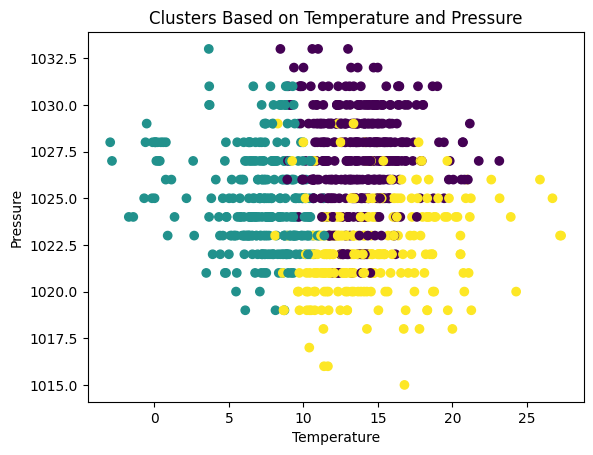

Centroids of the clusters: [[ 0.64108136  0.22956739  0.37628403  0.55733559 -0.51256342  0.37664275]
 [-0.06923651  0.6167203  -0.34651082 -1.09437336  1.08154563 -1.0761296 ]
 [-0.85777193 -1.0154511  -0.16576069  0.39610907 -0.44719031  0.6392808 ]]


In [155]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que votre DataFrame s'appelle df
X = df[['Pressure', 'Humidity', 'Wind Speed', 'temp_rolling_avg', 'Heat Index', 'Wind Chill']]

# Normalisation des données (optionnel, mais conseillé pour K-Means)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer K-Means pour créer 3 clusters (vous pouvez essayer différentes valeurs de K)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Afficher les résultats
print(df[['City', 'Temperature', 'Cluster']])

# Visualisation des clusters (si vous avez des données en 2D ou 3D)
plt.scatter(df['Temperature'], df['Pressure'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Clusters Based on Temperature and Pressure')
plt.show()

# Centres des clusters
centroids = kmeans.cluster_centers_
print("Centroids of the clusters:", centroids)


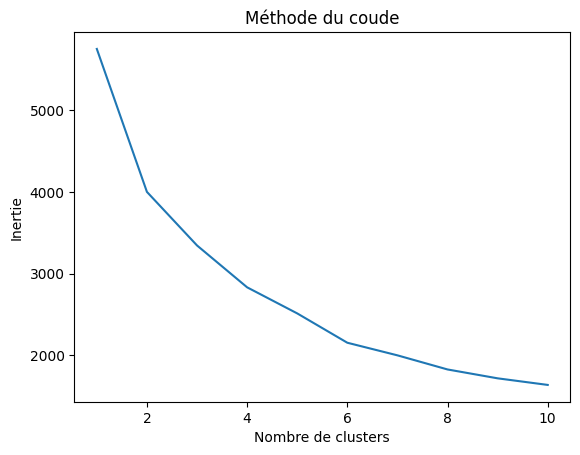

In [156]:
inertia = []
for k in range(1, 11):  # Tester k de 1 à 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()
